<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 11:15:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'GBPUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 177 kB 23.8 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 133 kB 30.1 MB/s 
     |████████████████████████████████| 138 kB 28.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 979 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 9qlyge3o
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/9qlyge3o


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: bi3qzoaq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
32/32 [==============================] - 15s 25ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - mean_absolute_error: 0.2874 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1211
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0814
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0356 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0732
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0331 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0774
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0

epoch,49
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01489
val_loss,0.00177
val_mean_squared_error,0.00177
val_mean_absolute_error,0.03215
_runtime,31
_timestamp,1627038965
_step,49
best_val_loss,0.00177


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oj60zzxu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 1s 18ms/step - loss: 0.2607 - mean_squared_error: 0.2607 - mean_absolute_error: 0.4244 - val_loss: 0.0836 - val_mean_squared_error: 0.0836 - val_mean_absolute_error: 0.2168
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2553 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1891
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1944 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1808
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1850 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1687
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0370 - mean_squared_erro

epoch,57
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.03335
val_loss,0.00941
val_mean_squared_error,0.00941
val_mean_absolute_error,0.07768
_runtime,15
_timestamp,1627039000
_step,57
best_val_loss,0.00938


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gadj80bn with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 2s 18ms/step - loss: 1.0606 - mean_squared_error: 1.0606 - mean_absolute_error: 0.3775 - val_loss: 0.1459 - val_mean_squared_error: 0.1459 - val_mean_absolute_error: 0.3558
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - mean_absolute_error: 0.1802 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0799
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1050 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0771
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0789 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1194
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0262 - mean_squared_erro

epoch,37
loss,0.00288
mean_squared_error,0.00288
mean_absolute_error,0.03945
val_loss,0.0052
val_mean_squared_error,0.0052
val_mean_absolute_error,0.05896
_runtime,12
_timestamp,1627039039
_step,37
best_val_loss,0.00237


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▄▃▂▃▂▃▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▂▁▁▁▁▃▂▁▂▁▁▁▁▁▁▃▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▂▁▁▁▁▃▂▁▂▁▁▁▁▁▁▃▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▃▂▁▁▁▅▂▁▂▁▁▁▁▁▁▄▂▁▄▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h3hlnwp2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 68ms/step - loss: 0.1416 - mean_squared_error: 0.1416 - mean_absolute_error: 0.2792 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0947
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - mean_absolute_error: 0.1592 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0801
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0904 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0774
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0728 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0703
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0086 - mean_squared_error: 0.008

epoch,20
loss,0.00728
mean_squared_error,0.00728
mean_absolute_error,0.07357
val_loss,0.00747
val_mean_squared_error,0.00747
val_mean_absolute_error,0.0707
_runtime,7
_timestamp,1627039055
_step,20
best_val_loss,0.0065


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▆▂▁▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁
mean_squared_error,█▆▂▁▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁
mean_absolute_error,█▇▃▂▃▃▂▂▃▂▂▁▂▂▁▃▂▁▁▂▂
val_loss,▃▂▂▁█▂▁▂▂▂▁▂▂▁▂▂▁▁▁▁▁
val_mean_squared_error,▃▂▂▁█▂▁▂▂▂▁▂▂▁▂▂▁▁▁▁▁
val_mean_absolute_error,▄▂▂▁█▃▁▂▂▂▁▂▃▁▂▂▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅████
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅████
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m0xyl8su with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 34ms/step - loss: 0.2139 - mean_squared_error: 0.2139 - mean_absolute_error: 0.3666 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.1010
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0525 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0708
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0383 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0689
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0381 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0683
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.

epoch,49
loss,0.00064
mean_squared_error,0.00064
mean_absolute_error,0.01828
val_loss,0.00254
val_mean_squared_error,0.00254
val_mean_absolute_error,0.04055
_runtime,33
_timestamp,1627039105
_step,49
best_val_loss,0.00254


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁
val_loss,█▄▄▄▆▅▄▄▃▃▂▃▂▂▄▂▂▂▂▂▂▁▁▁▂▂▂▃▂▁▂▂▁▂▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▆▅▄▄▃▃▂▃▂▂▄▂▂▂▂▂▂▁▁▁▂▂▂▃▂▁▂▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▆▅▄▄▃▃▃▃▂▂▄▂▃▂▂▂▂▂▁▁▂▂▂▃▂▁▂▂▁▃▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cvj8ncv9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 2s 35ms/step - loss: 0.2859 - mean_squared_error: 0.2859 - mean_absolute_error: 0.3405 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0847
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1052 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0779
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1035 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0765
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0655 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0734
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0100 - mean_squared_erro

epoch,31
loss,0.00214
mean_squared_error,0.00214
mean_absolute_error,0.03021
val_loss,0.00514
val_mean_squared_error,0.00514
val_mean_absolute_error,0.05738
_runtime,9
_timestamp,1627039120
_step,31
best_val_loss,0.0021


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▄▃▃▃▃▃▃▃▃▁▃▂▃▂▂▂▂▂▂▃▂▂▃▁▂▁
val_loss,▄▄▄▃▃▃▃█▆▃▄▃▂▁▂▂▁▁▁▄▅▁▁▃▂▅▄▂▄▂▂▂
val_mean_squared_error,▄▄▄▃▃▃▃█▆▃▄▃▂▁▂▂▁▁▁▄▅▁▁▃▂▅▄▂▄▂▂▂
val_mean_absolute_error,▆▅▅▄▄▃▄█▆▄▅▄▃▂▂▃▁▁▁▅▇▁▁▄▃▆▆▃▆▃▃▃
_runtime,▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 4oneebwv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 0.3555 - mean_squared_error: 0.3555 - mean_absolute_error: 0.3567 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1424
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1199 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0917
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0857 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1469
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1094 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1499
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0158 - mean_squared_erro

epoch,46
loss,0.00295
mean_squared_error,0.00295
mean_absolute_error,0.04067
val_loss,0.00423
val_mean_squared_error,0.00423
val_mean_absolute_error,0.05139
_runtime,15
_timestamp,1627039142
_step,46
best_val_loss,0.00388


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▇█▃▃▂▂▅▄▂▂▂▃▅▂▄▆▂▄▁▂▁▃▁▂▄▁▁▁▁▁▂▁▁▃▁▁▁▁
val_mean_squared_error,█▃▇█▃▃▂▂▅▄▂▂▂▃▅▂▄▆▂▄▁▂▁▃▁▂▄▁▁▁▁▁▂▁▁▃▁▁▁▁
val_mean_absolute_error,▇▄██▃▃▃▂▆▅▃▃▂▄▆▂▅▆▂▅▂▂▁▄▁▃▅▁▁▁▁▁▂▂▁▄▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 35hdtgev with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 73ms/step - loss: 0.1532 - mean_squared_error: 0.1532 - mean_absolute_error: 0.2902 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_mean_absolute_error: 0.2537
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1498 - val_loss: 0.0813 - val_mean_squared_error: 0.0813 - val_mean_absolute_error: 0.2365
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1424 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0997
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0418 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0913
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0057 - mean_squared_error: 0.00

epoch,13
loss,0.01127
mean_squared_error,0.01127
mean_absolute_error,0.07238
val_loss,0.01326
val_mean_squared_error,0.01326
val_mean_absolute_error,0.0923
_runtime,6
_timestamp,1627039156
_step,13
best_val_loss,0.01302


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▃▃▁▁▂▁▂▂▂▁▂▂▂
mean_squared_error,█▃▃▁▁▂▁▂▂▂▁▂▂▂
mean_absolute_error,█▅▄▁▂▄▂▃▄▃▂▃▃▂
val_loss,▇█▁▁▂▁▁▃▂▁▁▂▄▁
val_mean_squared_error,▇█▁▁▂▁▁▃▂▁▁▂▄▁
val_mean_absolute_error,█▇▁▁▃▁▁▃▂▂▁▂▄▁
_runtime,▁▁▁▁██████████
_timestamp,▁▁▁▁██████████
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: iijdb4s9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 33ms/step - loss: 0.0545 - mean_squared_error: 0.0545 - mean_absolute_error: 0.1458 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0648
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0408 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0602
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0333 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0586
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0273 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0600
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.

epoch,49
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01548
val_loss,0.0018
val_mean_squared_error,0.0018
val_mean_absolute_error,0.03236
_runtime,12
_timestamp,1627039176
_step,49
best_val_loss,0.00165


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_loss,█▇▇▇▄▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▄▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▅▅▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nd9jt8em with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 1s 18ms/step - loss: 0.1284 - mean_squared_error: 0.1284 - mean_absolute_error: 0.2282 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0976
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0434 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0802
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0367 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0721
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0335 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0682
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,49
loss,0.00058
mean_squared_error,0.00058
mean_absolute_error,0.01743
val_loss,0.00252
val_mean_squared_error,0.00252
val_mean_absolute_error,0.04079
_runtime,16
_timestamp,1627039202
_step,49
best_val_loss,0.00252


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l00s92ec with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 2s 20ms/step - loss: 0.2306 - mean_squared_error: 0.2306 - mean_absolute_error: 0.3946 - val_loss: 0.0500 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.2016
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1838 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1558
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1483 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1355
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1059 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1122
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0074 - mean_squared_erro

epoch,199
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02503
val_loss,0.00511
val_mean_squared_error,0.00511
val_mean_absolute_error,0.05635
_runtime,47
_timestamp,1627039256
_step,199
best_val_loss,0.00511


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: svfdb8st with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 32ms/step - loss: 0.2377 - mean_squared_error: 0.2377 - mean_absolute_error: 0.3862 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0911
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0760 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0622
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0461 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0556
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0346 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0514
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_erro

epoch,61
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01723
val_loss,0.00189
val_mean_squared_error,0.00189
val_mean_absolute_error,0.03429
_runtime,14
_timestamp,1627039318
_step,61
best_val_loss,0.00159


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h1a5abzr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 2s 19ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - mean_absolute_error: 0.1574 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0698
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0512 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0652
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0594 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0900
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0572 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1037
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_erro

epoch,77
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02448
val_loss,0.00304
val_mean_squared_error,0.00304
val_mean_absolute_error,0.0418
_runtime,24
_timestamp,1627039351
_step,77
best_val_loss,0.00231


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃█▇▃▇▃▂▂▂▂▂▃▂▂▂▂▂▁▂▁▁▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▄▃█▇▃▇▃▂▂▂▂▂▃▂▂▂▂▂▁▂▁▁▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄█▇▃▇▃▂▂▂▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kr3c9qm2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 72ms/step - loss: 0.1469 - mean_squared_error: 0.1469 - mean_absolute_error: 0.3021 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1222
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0936 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0945
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0623 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0821
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0487 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0781
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mea

epoch,49
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01563
val_loss,0.00212
val_mean_squared_error,0.00212
val_mean_absolute_error,0.03677
_runtime,10
_timestamp,1627039370
_step,49
best_val_loss,0.00212


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tlg3yynp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 35ms/step - loss: 0.2493 - mean_squared_error: 0.2493 - mean_absolute_error: 0.4141 - val_loss: 0.0508 - val_mean_squared_error: 0.0508 - val_mean_absolute_error: 0.1690
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0537 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1978 - val_loss: 0.0519 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.2060
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1702 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1529
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1464 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1353
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0211 - mean_squared_error: 0.

epoch,49
loss,0.00191
mean_squared_error,0.00191
mean_absolute_error,0.03231
val_loss,0.0084
val_mean_squared_error,0.0084
val_mean_absolute_error,0.07278
_runtime,12
_timestamp,1627039396
_step,49
best_val_loss,0.0084


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pt1upr1e with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 34ms/step - loss: 0.3133 - mean_squared_error: 0.3133 - mean_absolute_error: 0.4694 - val_loss: 0.1947 - val_mean_squared_error: 0.1947 - val_mean_absolute_error: 0.3631
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.2386 - mean_squared_error: 0.2386 - mean_absolute_error: 0.4025 - val_loss: 0.1200 - val_mean_squared_error: 0.1200 - val_mean_absolute_error: 0.2647
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.1446 - mean_squared_error: 0.1446 - mean_absolute_error: 0.2959 - val_loss: 0.0688 - val_mean_squared_error: 0.0688 - val_mean_absolute_error: 0.1960
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - mean_absolute_error: 0.2431 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1761
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0620 - mean_squared_error: 0.

epoch,49
loss,0.00232
mean_squared_error,0.00232
mean_absolute_error,0.03587
val_loss,0.01012
val_mean_squared_error,0.01012
val_mean_absolute_error,0.08029
_runtime,13
_timestamp,1627039418
_step,49
best_val_loss,0.0101


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ogfupj0p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 37ms/step - loss: 0.0982 - mean_squared_error: 0.0982 - mean_absolute_error: 0.2101 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0883
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0642 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1227
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0599 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0985
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0551 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0944
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.

epoch,21
loss,0.0027
mean_squared_error,0.0027
mean_absolute_error,0.04131
val_loss,0.01192
val_mean_squared_error,0.01192
val_mean_absolute_error,0.08562
_runtime,9
_timestamp,1627039439
_step,21
best_val_loss,0.00602


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁
mean_absolute_error,█▄▄▃▃▄▃▃▂▃▃▂▃▃▂▂▃▂▁▂▃▂
val_loss,▃█▅▄▂▃▁▂▁▁▁▁▃▄▂▅▂▃▂▃▂▄
val_mean_squared_error,▃█▅▄▂▃▁▂▁▁▁▁▃▄▂▅▂▃▂▃▂▄
val_mean_absolute_error,▄█▅▅▃▃▂▂▁▂▂▁▃▅▂▅▂▄▂▃▂▄
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 6y4xd8k8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 36ms/step - loss: 0.8392 - mean_squared_error: 0.8392 - mean_absolute_error: 0.5009 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1035
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0521 - val_loss: 0.0594 - val_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.2021
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.1535 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0759
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.0950 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1021
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.

epoch,26
loss,0.00444
mean_squared_error,0.00444
mean_absolute_error,0.0421
val_loss,0.00258
val_mean_squared_error,0.00258
val_mean_absolute_error,0.04
_runtime,11
_timestamp,1627039459
_step,26
best_val_loss,0.00257


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▂▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▅▅▂▄▃▃▅▁▅▁▂▄▁▂▃▂▃▂▂▃▂▃▂▃▂
val_loss,▂█▂▃▃█▁▂▁▃▁▂▁▁▃▂▁▁█▁▂▆▁▂▁▃▁
val_mean_squared_error,▂█▂▃▃█▁▂▁▃▁▂▁▁▃▂▁▁█▁▂▆▁▂▁▃▁
val_mean_absolute_error,▃▇▂▃▃█▂▃▁▄▁▂▁▁▅▃▁▁█▁▂▆▁▃▂▄▁
_runtime,▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: sgqkysx4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 67ms/step - loss: 2.4308 - mean_squared_error: 2.4308 - mean_absolute_error: 1.1973 - val_loss: 0.4862 - val_mean_squared_error: 0.4862 - val_mean_absolute_error: 0.6289
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.4128 - mean_squared_error: 0.4128 - mean_absolute_error: 0.5273 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1515
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1442 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1724
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_error: 0.1401 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0691
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0079 - mean_squared_error: 0.007

epoch,40
loss,0.72106
mean_squared_error,0.72106
mean_absolute_error,0.71093
val_loss,0.01977
val_mean_squared_error,0.01977
val_mean_absolute_error,0.11642
_runtime,11
_timestamp,1627039479
_step,40
best_val_loss,0.00216


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▃▁
mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▃▁
mean_absolute_error,▃▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▆▅▃
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▂▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▂▁▁
val_mean_absolute_error,▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▃▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: h5g5zjwq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 1s 64ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1613 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1626
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0761 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0952
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0557 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1046
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0534 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0975
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0043 

epoch,199
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.02246
val_loss,0.00369
val_mean_squared_error,0.00369
val_mean_absolute_error,0.04864
_runtime,27
_timestamp,1627039518
_step,199
best_val_loss,0.00369


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n32ts0zg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 36ms/step - loss: 0.0987 - mean_squared_error: 0.0987 - mean_absolute_error: 0.2311 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1400
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.1048 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0916
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0925 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1266
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0821 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1190
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_err

epoch,26
loss,0.01489
mean_squared_error,0.01489
mean_absolute_error,0.08855
val_loss,0.00557
val_mean_squared_error,0.00557
val_mean_absolute_error,0.06021
_runtime,12
_timestamp,1627039541
_step,26
best_val_loss,0.0051


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▃▃▂▂▂▂▂▂▂▁▁▁▃▁▂▁▁▁▂▁▁▁▁▁▂▃
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▁▁▃▁▂▁▁▁▂▁▁▁▁▁▂▃
mean_absolute_error,█▄▄▄▃▃▄▃▃▃▁▂▂▄▁▃▂▁▂▃▁▂▂▁▂▃▄
val_loss,█▃▇▆▃▄▆▃▅▂▁▁▄▁▂▁▁▁▂▁▂▂▁▁▁▃▁
val_mean_squared_error,█▃▇▆▃▄▆▃▅▂▁▁▄▁▂▁▁▁▂▁▂▂▁▁▁▃▁
val_mean_absolute_error,█▄▇▆▃▄▆▃▅▃▂▁▄▁▂▁▁▂▂▂▂▂▂▂▁▃▁
_runtime,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: u0xtnrzs with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 69ms/step - loss: 0.1252 - mean_squared_error: 0.1252 - mean_absolute_error: 0.2533 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0950
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0760 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0849
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0609 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0866
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0958
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0100 - mean_squared_error: 0.0100 

epoch,42
loss,0.0044
mean_squared_error,0.0044
mean_absolute_error,0.05433
val_loss,0.00614
val_mean_squared_error,0.00614
val_mean_absolute_error,0.06422
_runtime,10
_timestamp,1627039563
_step,42
best_val_loss,0.00578


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▂▁▁▂▂
val_loss,▆▄▅▇▄█▃▄▃▂▂▂▃▃▂▂▃▂▁▃▂▃▂▂▂▂▁▁▁▄▁▂▁▂▁▁▂▂▁▁
val_mean_squared_error,▆▄▅▇▄█▃▄▃▂▂▂▃▃▂▂▃▂▁▃▂▃▂▂▂▂▁▁▁▄▁▂▁▂▁▁▂▂▁▁
val_mean_absolute_error,▇▅▅▇▅█▃▅▄▃▃▃▄▄▂▂▄▃▁▄▂▄▃▂▂▂▁▁▁▅▁▂▂▂▁▁▂▃▂▁
_runtime,▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 2fke7fnl with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 2s 21ms/step - loss: 0.2016 - mean_squared_error: 0.2016 - mean_absolute_error: 0.2618 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0553
Epoch 2/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0359 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0468
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0280 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0425
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0242 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0410
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 8.9659e-04 - mean_squared_

epoch,46
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.0144
val_loss,0.00137
val_mean_squared_error,0.00137
val_mean_absolute_error,0.02926
_runtime,20
_timestamp,1627039594
_step,46
best_val_loss,0.00131


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▆▄▄▃▂▂▂▂▂▄▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▃▂▁▁▁▁
val_mean_squared_error,█▆▄▄▃▂▂▂▂▂▄▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▃▂▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▂▂▂▂▅▂▃▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▁▁▁▁▁▂▄▃▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 80hkjhxa with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 66ms/step - loss: 0.2341 - mean_squared_error: 0.2341 - mean_absolute_error: 0.3989 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1661
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.2035 - val_loss: 0.0565 - val_mean_squared_error: 0.0565 - val_mean_absolute_error: 0.2144
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1731 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1362
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1520 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1380
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0163 - mean_squared_error: 0.0163

epoch,99
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.0289
val_loss,0.00707
val_mean_squared_error,0.00707
val_mean_absolute_error,0.06609
_runtime,15
_timestamp,1627039624
_step,99
best_val_loss,0.00684


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: svuo4g1u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 21ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1379 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0869
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0595 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1276
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0639 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0792
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0438 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0782
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.

epoch,49
loss,0.00196
mean_squared_error,0.00196
mean_absolute_error,0.0333
val_loss,0.00385
val_mean_squared_error,0.00385
val_mean_absolute_error,0.04672
_runtime,20
_timestamp,1627039654
_step,49
best_val_loss,0.00273


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂
val_loss,▄█▃▄▄▂▂▂▂▂▂▂▂▅▃▂▁▂▁▃▃▁▁▂▂▃▁▁▁▁▁▂▁▃▁▂▃▁▁▁
val_mean_squared_error,▄█▃▄▄▂▂▂▂▂▂▂▂▅▃▂▁▂▁▃▃▁▁▂▂▃▁▁▁▁▁▂▁▃▁▂▃▁▁▁
val_mean_absolute_error,▅█▄▄▄▃▃▂▂▃▂▂▃▆▄▂▂▃▂▄▄▂▁▂▂▃▂▂▁▁▂▂▂▃▁▂▄▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vb2uxjuu with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 2s 37ms/step - loss: 90.4200 - mean_squared_error: 90.4200 - mean_absolute_error: 5.2176 - val_loss: 0.0516 - val_mean_squared_error: 0.0516 - val_mean_absolute_error: 0.1911
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1242 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1624
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.1236 - mean_squared_error: 0.1236 - mean_absolute_error: 0.2283 - val_loss: 0.0474 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1756
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.1553 - mean_squared_error: 0.1553 - mean_absolute_error: 0.2746 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1519
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0818 - mean_squared_er

epoch,25
loss,0.05806
mean_squared_error,0.05806
mean_absolute_error,0.16176
val_loss,0.00749
val_mean_squared_error,0.00749
val_mean_absolute_error,0.06967
_runtime,10
_timestamp,1627039675
_step,25
best_val_loss,0.00692


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
mean_absolute_error,█▁▂▂▂▃▁▁▃▁▁▁▃▁▁▁▃▂▁▁▁▅▁▁▁▁
val_loss,▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁█▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁█▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▂▂▂▁▃▂▁▂▁▂▁▁▅▁▁▁█▁▁▂▂▁▁▄▁▁
_runtime,▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆██████
_timestamp,▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆██████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: bfmf64x8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 35ms/step - loss: 0.2325 - mean_squared_error: 0.2325 - mean_absolute_error: 0.4008 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0918
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0649 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0822
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0415 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0711
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0305 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0670
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0017 - mean_squared_err

epoch,99
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02333
val_loss,0.00194
val_mean_squared_error,0.00194
val_mean_absolute_error,0.03463
_runtime,24
_timestamp,1627039710
_step,99
best_val_loss,0.00193


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▅▃▃▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▅▃▃▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▅▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x785oq89 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 36ms/step - loss: 0.2049 - mean_squared_error: 0.2049 - mean_absolute_error: 0.3639 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1580
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1245 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1018
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0475 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0824
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0410 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0825
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,49
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02778
val_loss,0.00624
val_mean_squared_error,0.00624
val_mean_absolute_error,0.06173
_runtime,15
_timestamp,1627039737
_step,49
best_val_loss,0.00624


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v9c9zech with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 34ms/step - loss: 0.3113 - mean_squared_error: 0.3113 - mean_absolute_error: 0.4723 - val_loss: 0.1285 - val_mean_squared_error: 0.1285 - val_mean_absolute_error: 0.2913
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2444 - val_loss: 0.0524 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.2082
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1222 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0967
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0685 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0907
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.

epoch,49
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01822
val_loss,0.00301
val_mean_squared_error,0.00301
val_mean_absolute_error,0.04347
_runtime,16
_timestamp,1627039764
_step,49
best_val_loss,0.00294


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pp4ajfrn with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 21ms/step - loss: 0.1756 - mean_squared_error: 0.1756 - mean_absolute_error: 0.2948 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0767
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0530 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0749
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0459 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0599
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0742 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0713
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_erro

epoch,85
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01496
val_loss,0.00247
val_mean_squared_error,0.00247
val_mean_absolute_error,0.03972
_runtime,33
_timestamp,1627039811
_step,85
best_val_loss,0.00149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▇▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▆▄▃▃▃▂▂▂▂▂▁▂▁▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▄▃▃▃▂▂▂▂▂▁▂▁▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▂▂▁▁█▁▁▁▂▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: efa4mbhj with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 33ms/step - loss: 0.3581 - mean_squared_error: 0.3581 - mean_absolute_error: 0.3600 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1338
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1549 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0927
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1377 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1460
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1091 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1423
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0195 - mean_squared_error: 0.

epoch,46
loss,0.00368
mean_squared_error,0.00368
mean_absolute_error,0.04546
val_loss,0.00269
val_mean_squared_error,0.00269
val_mean_absolute_error,0.04095
_runtime,14
_timestamp,1627039848
_step,46
best_val_loss,0.00206


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▇▆▆▅▄▄▂▃▂▃▂▃▃▁▃▃▁▃▁▂▂▂▂▁▂▂▂▁▂▁▂▁▁▂▁▂▁▂
val_loss,▆▃▇▆█▄▂▁▇▃▁▁▃▁▁▁▁▁▁▁▁█▁▁▁▃▁▁▁▂▂▁▂▁▁▁▂▁▂▁
val_mean_squared_error,▆▃▇▆█▄▂▁▇▃▁▁▃▁▁▁▁▁▁▁▁█▁▁▁▃▁▁▁▂▂▁▂▁▁▁▂▁▂▁
val_mean_absolute_error,▆▄▇▇█▅▂▂▇▄▁▂▄▁▁▂▂▁▁▁▁█▂▁▁▄▁▁▂▂▃▁▃▁▁▁▂▁▂▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: te0njdcv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 137ms/step - loss: inf - mean_squared_error: inf - mean_absolute_error: inf - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - va

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627039869
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▁██████
_timestamp,▁▁▁▁██████
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 83ap7zwh with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 66ms/step - loss: 0.1803 - mean_squared_error: 0.1803 - mean_absolute_error: 0.3306 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.1014
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0616 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0849
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0389 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0718
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0557 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0702
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - me

epoch,49
loss,0.0021
mean_squared_error,0.0021
mean_absolute_error,0.03649
val_loss,0.00719
val_mean_squared_error,0.00719
val_mean_absolute_error,0.06583
_runtime,12
_timestamp,1627039898
_step,49
best_val_loss,0.00496


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▂▂▁▂▁▁▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁
val_loss,█▅▃▃▃▅▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▂▁▅▂▂▄▃▃
val_mean_squared_error,█▅▃▃▃▅▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▂▁▅▂▂▄▃▃
val_mean_absolute_error,█▅▃▃▃▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▅▂▂▃▃▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u58wh83y with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 70ms/step - loss: 0.0596 - mean_squared_error: 0.0596 - mean_absolute_error: 0.1861 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0764
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0875 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0817
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0860 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0705
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0713 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0597
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0

epoch,66
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02688
val_loss,0.00393
val_mean_squared_error,0.00393
val_mean_absolute_error,0.05054
_runtime,15
_timestamp,1627039931
_step,66
best_val_loss,0.00224


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▂▃▂▂▃▂▂▂▂▁▃▂▂▂▃▁▁▂▁▁▂▂▂▁▁▂▂▁▁▂▂▁▁▁▂▁▂
val_loss,▆▆▃▂█▂▂▂▂▂▃▂▂▂▂▂▃▂▁▂▃▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁▂
val_mean_squared_error,▆▆▃▂█▂▂▂▂▂▃▂▂▂▂▂▃▂▁▂▃▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁▂
val_mean_absolute_error,▅▆▃▃█▃▃▃▃▂▄▂▂▃▂▂▄▂▂▂▃▂▁▃▂▁▁▁▃▁▁▁▂▂▁▂▂▂▁▂
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: l01dm1jr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 21ms/step - loss: 0.2264 - mean_squared_error: 0.2264 - mean_absolute_error: 0.3233 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0744
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1219 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0942
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1113 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.2257
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1299 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0872
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0149 - mean_squared_erro

epoch,67
loss,0.00271
mean_squared_error,0.00271
mean_absolute_error,0.0411
val_loss,0.00994
val_mean_squared_error,0.00994
val_mean_absolute_error,0.08368
_runtime,24
_timestamp,1627039969
_step,67
best_val_loss,0.00332


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▆▅▅▃█▇▂▂▃▄▃▂▄▅▂▃▃▇▃▃▃▁▃▄▂▁▁▃▄▂▁▁▄▂▁▂▂▁▄
val_mean_squared_error,▃▆▅▅▃█▇▂▂▃▄▃▂▄▅▂▃▃▇▃▃▃▁▃▄▂▁▁▃▄▂▁▁▄▂▁▂▂▁▄
val_mean_absolute_error,▄▆▅▅▄█▇▃▃▃▄▄▂▅▆▂▃▃▇▄▄▄▁▄▄▃▁▁▄▄▃▁▂▄▃▁▂▃▂▅
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mtay1hax with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 62ms/step - loss: 0.1278 - mean_squared_error: 0.1278 - mean_absolute_error: 0.2582 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0874
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0826 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0790
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0656 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0754
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0684 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0824
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - me

epoch,49
loss,0.00259
mean_squared_error,0.00259
mean_absolute_error,0.0412
val_loss,0.00531
val_mean_squared_error,0.00531
val_mean_absolute_error,0.059
_runtime,12
_timestamp,1627039993
_step,49
best_val_loss,0.00447


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▃▂▃▂▃▂▃▂▁▃▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▂▂▂▂▂▁▂▁▂▂▁
val_loss,█▆▅▇▅█▄▆▄▄▆▃▃▃▃▅▃▃▃▂▃▂▅▂▆▃▂▄▂▃▃▁▂▃▂▂▅▁▂▂
val_mean_squared_error,█▆▅▇▅█▄▆▄▄▆▃▃▃▃▅▃▃▃▂▃▂▅▂▆▃▂▄▂▃▃▁▂▃▂▂▅▁▂▂
val_mean_absolute_error,█▆▆▇▅▇▅▆▄▅▆▄▃▄▄▅▄▃▃▂▄▃▅▂▆▃▃▄▂▃▃▂▂▃▃▂▅▁▃▂
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 40qr8imt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 35ms/step - loss: 0.2075 - mean_squared_error: 0.2075 - mean_absolute_error: 0.3749 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1468
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1307 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0912
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0785 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1029
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0475 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0799
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_erro

epoch,99
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01364
val_loss,0.00177
val_mean_squared_error,0.00177
val_mean_absolute_error,0.03288
_runtime,26
_timestamp,1627040038
_step,99
best_val_loss,0.00177


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5na8e0ay with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 69ms/step - loss: 0.1695 - mean_squared_error: 0.1695 - mean_absolute_error: 0.2981 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1012
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0694 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0956
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0987
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0472 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0915
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_squared_error: 0.00

epoch,99
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02131
val_loss,0.00316
val_mean_squared_error,0.00316
val_mean_absolute_error,0.04299
_runtime,18
_timestamp,1627040069
_step,99
best_val_loss,0.00316


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mx6bna1e with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 2s 33ms/step - loss: 0.2179 - mean_squared_error: 0.2179 - mean_absolute_error: 0.2533 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1132
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1186 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1056
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1171 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0708
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0856 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0669
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0112 - mean_squared_erro

epoch,36
loss,0.00295
mean_squared_error,0.00295
mean_absolute_error,0.0386
val_loss,0.00208
val_mean_squared_error,0.00208
val_mean_absolute_error,0.03599
_runtime,14
_timestamp,1627040096
_step,36
best_val_loss,0.0018


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▄▅▄▄▄▃▃▂▂▃▂▁▂▂▂▂▂▂▃▁▂▁▂▂▁▁▂▁▁▂▂▁▁
val_loss,▆▅▃▃▃▃▅▂▂▂▂▆▂▂▃▅▁▂▃█▂▁▁▁▂▄▁▁▄▁▁▂▂▁▂▄▁
val_mean_squared_error,▆▅▃▃▃▃▅▂▂▂▂▆▂▂▃▅▁▂▃█▂▁▁▁▂▄▁▁▄▁▁▂▂▁▂▄▁
val_mean_absolute_error,▆▅▃▃▄▃▅▂▂▂▂▇▃▂▄▆▁▂▄█▃▁▁▁▂▄▁▂▄▁▁▃▂▁▃▅▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8k7i1nd4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 35ms/step - loss: 12.0768 - mean_squared_error: 12.0768 - mean_absolute_error: 2.4361 - val_loss: 0.2795 - val_mean_squared_error: 0.2795 - val_mean_absolute_error: 0.4044
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.2135 - mean_squared_error: 0.2135 - mean_absolute_error: 0.3696 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1250
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1100 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0691
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0485 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0576
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_er

epoch,46
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01884
val_loss,0.00151
val_mean_squared_error,0.00151
val_mean_absolute_error,0.02992
_runtime,16
_timestamp,1627040127
_step,46
best_val_loss,0.0014


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 56taanrn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 3.9130 - mean_squared_error: 3.9130 - mean_absolute_error: 1.2112 - val_loss: 0.1170 - val_mean_squared_error: 0.1170 - val_mean_absolute_error: 0.2851
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1649 - mean_squared_error: 0.1649 - mean_absolute_error: 0.2980 - val_loss: 0.0562 - val_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.2088
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0524 - mean_squared_error: 0.0524 - mean_absolute_error: 0.1848 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1134
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0629 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0790
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error:

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
40/40 [==============================] - 1s 4ms/step - loss: 0.0470
Epoch 2/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 7.5839e-04
Epoch 4/200
40/40 [==============================] - 0s 4ms/step - loss: 6.6527e-04
Epoch 5/200
40/40 [==============================] - 0s 4ms/step - loss: 6.4558e-04
Epoch 6/200
40/40 [==============================] - 0s 4ms/step - loss: 4.5518e-04
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 6.1808e-04
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 5.9417e-04
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 5.5360e-04
Epoch 10/200
40/40 [==============================] - 0s 4ms/step - loss: 6.3467e-04
Epoch 11/200
40/40 [==============================] - 0s 4ms/step - loss: 6.5853e-04
Epoch 12/200
40/40 [==============================] - 0s 3ms/step - loss: 6.4241e-

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

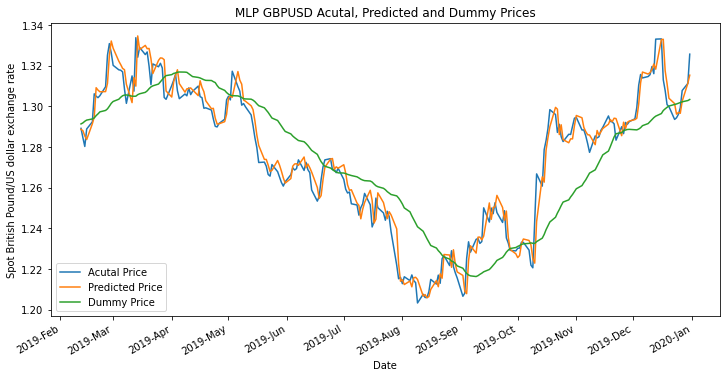

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

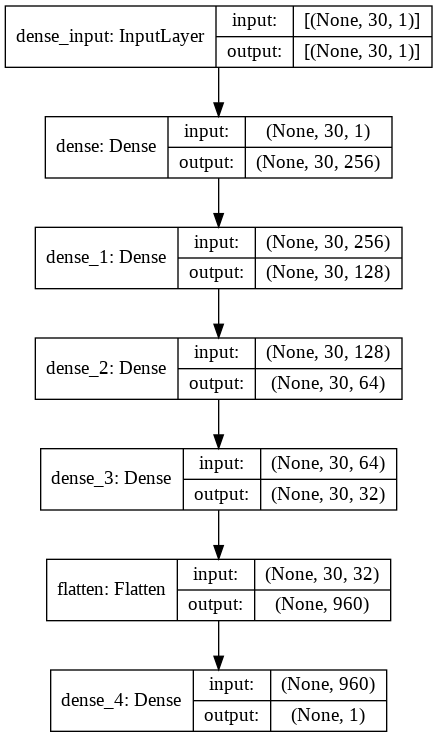

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0026418219340924643
RMSE:  0.05139865692887767
MAE:  0.03899305675998882
Dummy MSE:  0.02193382943864584
Dummy RMSE:  0.14810074084435176
Dummy MAE:  0.1194927932858967


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_GBPUSD/assets
